## Song Embeddings - Skipgram Recommender

In this notebook, we'll use human-made music playlists to learn song embeddings. We'll treat a playlist as if it's a sentence and the songs it contains as words. We feed that to the word2vec algorithm which then learns embeddings for every song we have. These embeddings can then be used to recommend similar songs. This technique is used by Spotify, AirBnB, Alibaba, and others. It accounts for a vast portion of their user activity, user media consumption, and/or sales (in the case of Alibaba).

The [dataset we'll use](https://www.cs.cornell.edu/~shuochen/lme/data_page.html) was collected by Shuo Chen from Cornell University. The dataset contains playlists from hundreds of radio stations from around the US.

## Importing packages and dataset

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from urllib import request
import warnings
warnings.filterwarnings('ignore')

The playlist dataset is a text file where every line represents a playlist. That playlist is basically a series of song IDs.

In [2]:
# Get the playlist dataset file
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

# Parse the playlist dataset file. Skip the first two lines as
# they only contain metadata
lines = data.read().decode("utf-8").split('\n')[2:]

# Remove playlists with only one song
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]


The `playlists` variable now contains a python list. Each item in this list is a playlist containing song ids. We can look at the first two playlists here:

In [3]:
print( 'Playlist #1:\n ', playlists[0], '\n')
print( 'Playlist #2:\n ', playlists[1])

Playlist #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

Playlist #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117',

## Training the Word2Vec Model
Our dataset is now in the shape the the Word2Vec model expects as input. We pass the dataset to the model.

In [4]:
model = Word2Vec(playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4)

The model is now trained. Every song has an embedding. We only have song IDs, though, no titles or other info. Let's grab the song information file.

## Song Title and Artist File
Let's load and parse the file containing song titles and artists

In [5]:
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode("utf-8").split('\n')
songs = [s.rstrip().split('\t') for s in songs_file]

In [6]:
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

In [7]:
songs_df.head()

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


In [8]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75263 entries, 0  to 
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   75262 non-null  object
 1   artist  75261 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [15]:
# Busquemos un ejemplo para cualquier artista
songs_df[songs_df.artist == 'Coldplay'].head()

,title,artist
id,,
3696,Viva La Vida,Coldplay
3958,Yellow,Coldplay
4140,Clocks,Coldplay
9407,Speed Of Sound,Coldplay
12990,Life In Technicolor,Coldplay


In [17]:
songs_df.iloc[3696]

,3696
title,Viva La Vida
artist,Coldplay


In [18]:
song_id = 3696

# Con la cancion #3696 el modelo selecciona las canciones recomendadas más cercanas a 1, es decir que de acuerdo son las mas similares.
model.wv.most_similar(positive=str(song_id))

[('3596', 0.9917376041412354),
 ('3978', 0.9873318076133728),
 ('4179', 0.9857209920883179),
 ('3802', 0.9856286644935608),
 ('3476', 0.9848978519439697),
 ('4082', 0.9828135371208191),
 ('100', 0.9807736873626709),
 ('3885', 0.9806487560272217),
 ('4162', 0.9794829487800598),
 ('3429', 0.9783392548561096)]

In [19]:
#Identificar los nombres y artistas recomendo el modelo :
similar_songs = np.array(model.wv.most_similar(positive=str(song_id)))[:,0]
songs_df.iloc[similar_songs]

,title,artist
id,,
3596,Your Body Is A Wonderland,John Mayer
3978,No Such Thing,John Mayer
4179,Something To Talk About,Bonnie Raitt
3802,Faith,George Michael
3476,Walking In Memphis,Marc Cohn
4082,Fast Car,Tracy Chapman
100,I'm Yours,Jason Mraz
3885,Bubbly,Colbie Caillat
4162,She Will Be Loved,Maroon 5


In [46]:
# Busquemos un ejemplo para otro artista
songs_df[songs_df.artist == 'Shakira'].head()

,title,artist
1401,She Wolf \/ Loba,Shakira
6983,"Waka Waka, Esto Es Africa (w\/ Freshly Ground)",Shakira
11882,Hips Don't Lie (w\/ Wyclef Jean),Shakira
13876,Loca,Shakira
14053,Las De La Intuicion,Shakira


In [47]:
songs_df.iloc[14053]

,14053
title,Las De La Intuicion
artist,Shakira


In [48]:
song_id = 14053

# Con la cancion #3696 el modelo selecciona las canciones recomendadas más cercanas a 1, es decir que de acuerdo son las mas similares.
model.wv.most_similar(positive=str(song_id))

[('5773', 0.9927759766578674),
 ('39426', 0.9922508001327515),
 ('35164', 0.9917780756950378),
 ('35926', 0.991630494594574),
 ('13919', 0.9915583729743958),
 ('27332', 0.9914897084236145),
 ('24861', 0.9914628863334656),
 ('13899', 0.9914349317550659),
 ('14753', 0.9912259578704834),
 ('35153', 0.9912053942680359)]

In [49]:
#Identificar los nombres y artistas recomendo el modelo :
similar_songs = np.array(model.wv.most_similar(positive=str(song_id)))[:,0]
songs_df.iloc[similar_songs]

,title,artist
5773,Ride Wit Me (w\/ City Spud),Nelly
39426,Disco Bolero,Charo
35164,All About The Kingdom,Canton Jones
35926,Bear Creek Blues,John Prine
13919,Desafio (w\/ Don Omar),Daddy Yankee
27332,I Do Believe,Steven Curtis Chapman
24861,Hard Habit To Break,Chicago
13899,Un Millon De Cicatrices,El Canto Del Loco
14753,Aguit A'e Coco,Afrosound
35153,Breezin',George Benson & Al Jarreau


In [20]:
def print_recommendations(song_id):
    print( songs_df.iloc[song_id] )
    similar_songs = np.array(model.wv.most_similar(positive=str(song_id)))[:,0]
    return  songs_df.iloc[similar_songs]


### Exercise:

Build visualization for the embeddings of the song recommender.

In [40]:
# Hay 1793 - (guiones) en el nombre del artista por lo que toca borrarlos
songs_df[songs_df['title'] == '-']
songs_df = songs_df[songs_df['title'] != '-']
songs_df = songs_df.reset_index(drop=True)
songs_df.head()

,title,artist
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


Number of clusters (n): 25, Top-n (m): 10, Embedding dimensions (k): 32


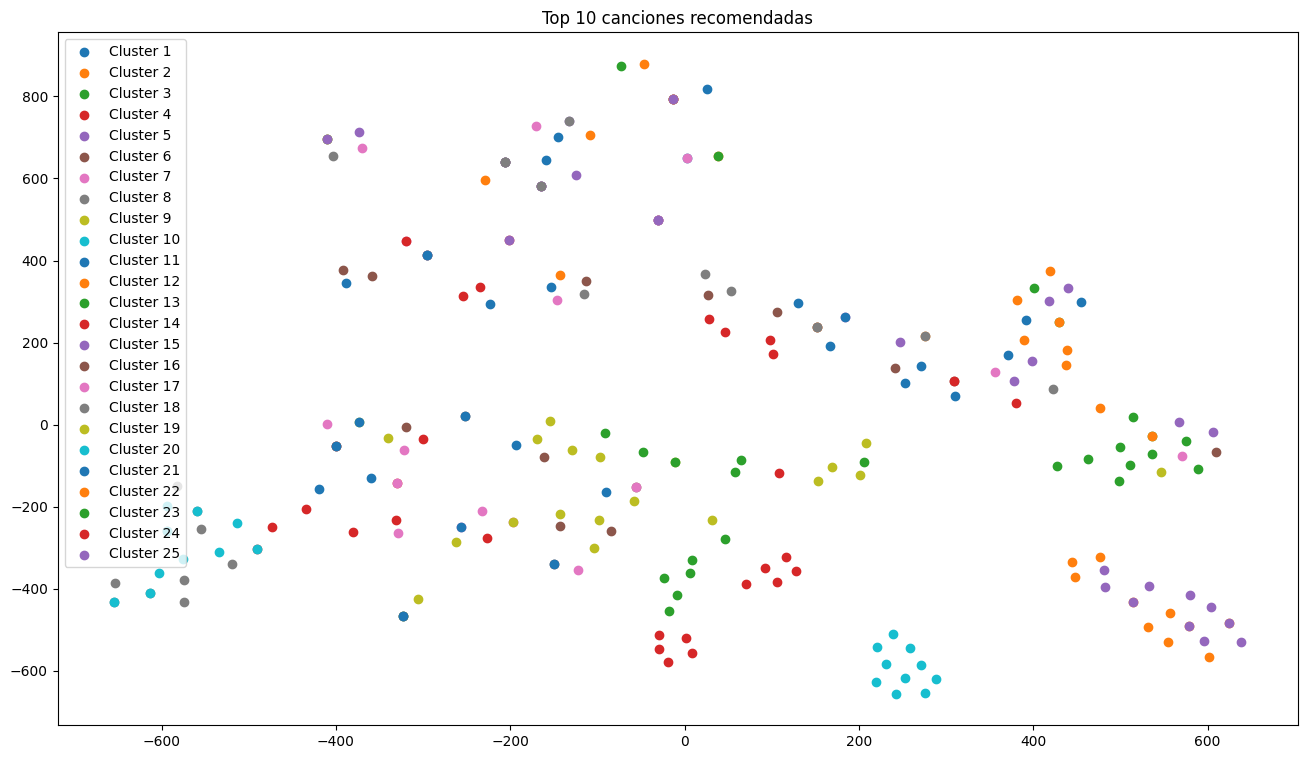

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Definimos los keys (índices) como en tu código
keys = list(range(73469))

# Inicializamos las listas para los embeddings y los títulos de canciones
embedding_clusters = []
word_clusters = []

# Limitar a 25 canciones (esto puede ajustarse según el tamaño de tus datos)
for word in keys[:25]:

    embeddings = []
    words = []

    # Obtenemos las 10 recomendaciones más similares para cada canción
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        song_index = int(similar_word)
        title = songs_df.iloc[song_index]['title']

        words.append(title)
        embeddings.append(model.wv[similar_word])

    # Añadimos los embeddings y palabras para cada cluster de canciones
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

# Convertir las listas a arrays de numpy para facilidad de manejo
embedding_clusters = np.array(embedding_clusters)

# Obtener las dimensiones del embedding
n, m, k = embedding_clusters.shape
print(f"Number of clusters (n): {n}, Top-n (m): {m}, Embedding dimensions (k): {k}")

# Ahora realizamos la reducción dimensional usando t-SNE para proyectar los embeddings a 2D
tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3000, random_state=32)
embeddings_2d = tsne_model.fit_transform(embedding_clusters.reshape(-1, k))

# Visualizar el resultado usando matplotlib
plt.figure(figsize=(16, 9))

# Dibujar cada cluster de recomendaciones
for i in range(n):
    plt.scatter(embeddings_2d[i*m:(i+1)*m, 0], embeddings_2d[i*m:(i+1)*m, 1], label=f"Cluster {i+1}")

plt.legend()
plt.title('Top 10 canciones recomendadas')
plt.show()


## Visualización con nombre, disminuimos la muestra para identficar las canciones

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Definimos los keys (índices) como en tu código
keys = list(range(73469))

# Inicializamos las listas para los embeddings y los títulos de canciones
embedding_clusters = []
word_clusters = []

# Limitar a 5 canciones
for word in keys[:5]:

    embeddings = []
    words = []

    # Obtenemos las 10 recomendaciones más similares para cada canción
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        song_index = int(similar_word)
        title = songs_df.iloc[song_index]['title']

        words.append(title)
        embeddings.append(model.wv[similar_word])

    # Añadimos los embeddings y palabras para cada cluster de canciones
    embedding_clusters.append(embeddings)
    word_clusters.append(words)


Number of clusters (n): 5, Top-n (m): 10, Embedding dimensions (k): 32


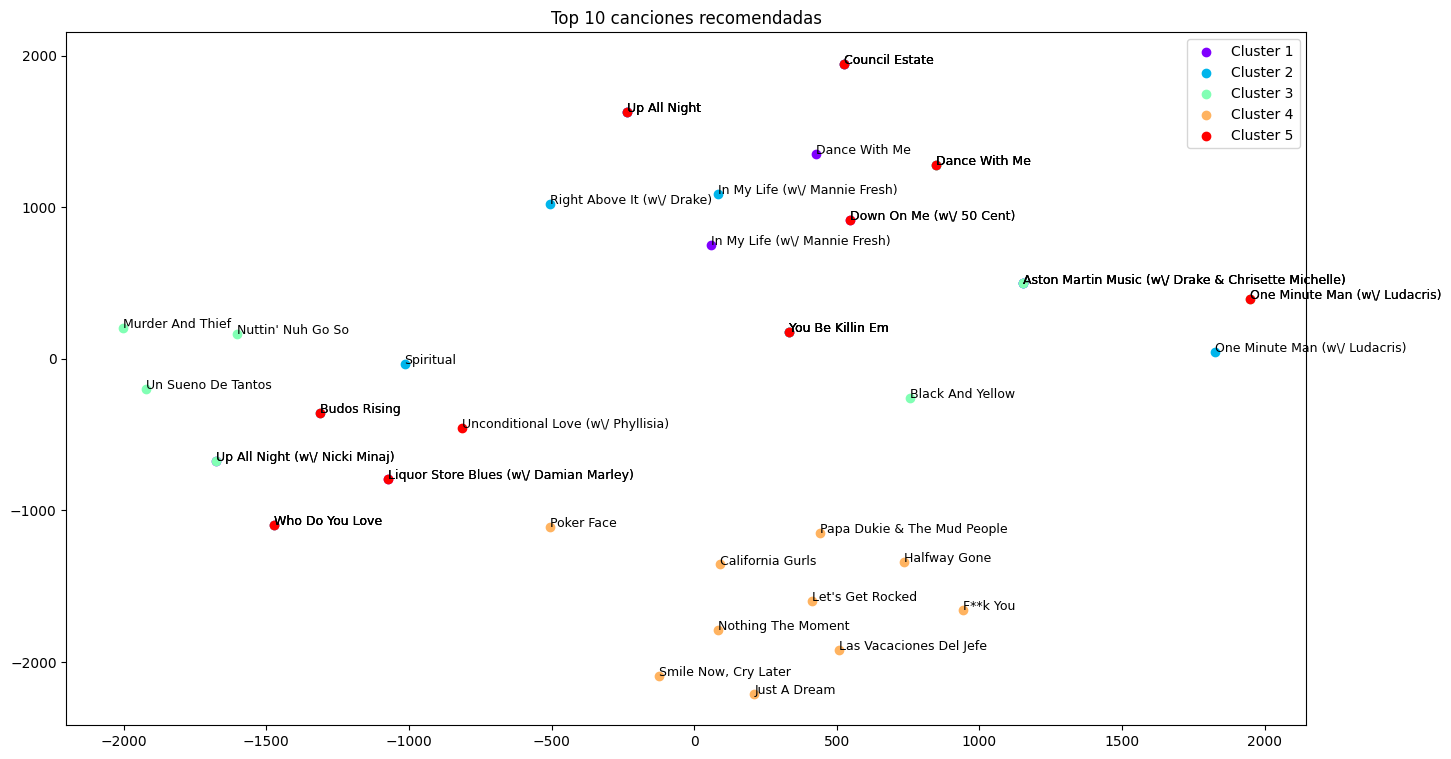

In [45]:
# Convertir las listas a arrays de numpy para facilidad de manejo
embedding_clusters = np.array(embedding_clusters)

# Obtener las dimensiones del embedding
n, m, k = embedding_clusters.shape
print(f"Number of clusters (n): {n}, Top-n (m): {m}, Embedding dimensions (k): {k}")

# Ahora realizamos la reducción dimensional usando t-SNE para proyectar los embeddings a 2D
tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3000, random_state=32)
embeddings_2d = tsne_model.fit_transform(embedding_clusters.reshape(-1, k))

# Reajustamos word_clusters como una lista plana para visualizarlo fácilmente
word_clusters_flat = [item for sublist in word_clusters for item in sublist]

# Visualizar el resultado usando matplotlib
plt.figure(figsize=(16, 9))

# Dibujar cada cluster de recomendaciones
colors = plt.cm.rainbow(np.linspace(0, 1, n))  # Colores para diferenciar clusters

for i in range(n):
    # Dibujamos los puntos
    plt.scatter(embeddings_2d[i*m:(i+1)*m, 0], embeddings_2d[i*m:(i+1)*m, 1], color=colors[i], label=f"Cluster {i+1}")

    # Añadimos los títulos de las canciones como etiquetas
    for j in range(m):
        plt.text(embeddings_2d[i*m+j, 0], embeddings_2d[i*m+j, 1], word_clusters[i][j], fontsize=9)

plt.legend()
plt.title('Top 10 canciones recomendadas')
plt.show()

# **Métrica de Evaluación Sistema de Recomendación**


DCG y nDCG

Discounted Cumulative Gain (DCG) es una métrica que penaliza si un dato relevante aparece bajo en el ranking.
Si el valor es 1 quiere decir que la recomendación es buena.




In [56]:
import numpy as np

# Función para calcular DCG
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    dcg = np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return dcg

# Función para calcular IDCG (DCG óptimo)
def idcg_at_k(relevance_scores, k):
    sorted_relevance_scores = sorted(relevance_scores, reverse=True)
    return dcg_at_k(sorted_relevance_scores, k)

# Función para calcular NDCG
def ndcg_at_k(relevance_scores, k):
    dcg = dcg_at_k(relevance_scores, k)
    idcg = idcg_at_k(relevance_scores, k)
    if idcg == 0:
        return 0
    return dcg / idcg


In [55]:
# Obtenemos las 10 canciones recomendadas para cada canción en el top-10
relevance_scores = []

for word in keys[:100]:
    embeddings = []
    words = []
    relevance = []

    # Obtenemos las 10 recomendaciones más similares para cada canción
    for similar_word, similarity_score in model.wv.most_similar(word, topn=10):
        song_index = int(similar_word)
        title = songs_df.iloc[song_index]['title']

        words.append(title)
        embeddings.append(model.wv[similar_word])

        # Define la relevancia de la canción, por ejemplo, basándote en el puntaje de similitud

        relevance.append(similarity_score)

    # Calculamos la métrica DCG para esta lista de recomendaciones
    k = 10  # Top K a considerar
    dcg_score = dcg_at_k(relevance, k)
    ndcg_score = ndcg_at_k(relevance, k)

    print(f"DCG@{k} para la canción {word}: {dcg_score}")
    print(f"NDCG@{k} para la canción {word}: {ndcg_score}")

    relevance_scores.append(relevance)


DCG@10 para la canción 0: 4.468719056148732
NDCG@10 para la canción 0: 1.0
DCG@10 para la canción 1: 4.47321528399488
NDCG@10 para la canción 1: 1.0
DCG@10 para la canción 2: 4.292264689836821
NDCG@10 para la canción 2: 1.0
DCG@10 para la canción 3: 4.334768389693207
NDCG@10 para la canción 3: 1.0
DCG@10 para la canción 4: 4.468706996606447
NDCG@10 para la canción 4: 1.0
DCG@10 para la canción 5: 4.488134518030159
NDCG@10 para la canción 5: 1.0
DCG@10 para la canción 6: 4.472680033821896
NDCG@10 para la canción 6: 1.0
DCG@10 para la canción 7: 4.263112651141065
NDCG@10 para la canción 7: 1.0
DCG@10 para la canción 8: 4.394384571141933
NDCG@10 para la canción 8: 1.0
DCG@10 para la canción 9: 4.387902359891321
NDCG@10 para la canción 9: 1.0
DCG@10 para la canción 10: 4.510648888537542
NDCG@10 para la canción 10: 1.0
DCG@10 para la canción 11: 4.360126572755704
NDCG@10 para la canción 11: 1.0
DCG@10 para la canción 12: 4.400890293106451
NDCG@10 para la canción 12: 1.0
DCG@10 para la canci